# Load the libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Input, Conv2D, MaxPooling2D,GlobalMaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Activation, MaxPool2D, AvgPool2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.applications import DenseNet121, VGG19, ResNet50
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from IPython.display import display, Image
import matplotlib.pyplot as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import warnings
warnings.filterwarnings("ignore")

from sklearn.utils import shuffle
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Updates
VERSION-16
1. Images displayed with labels and Histogram plots
2. CNN model developed with accuracy and loss plot
3. initiation of callbacks for the above models
4. DenseNet121 simplified 
5. Mobilenet_V2
6. Predictions 

# 1. Loading Datasets

In [2]:
train_df = pd.read_csv('../input/coronahack-chest-xraydataset/Chest_xray_Corona_Metadata.csv')
valid_df = pd.read_csv('../input/coronahack-chest-xraydataset/Chest_xray_Corona_dataset_Summary.csv')

print('The training dataset has rows : ', format(train_df.shape[0]))
print('The training dataset has cols : ', format(train_df.shape[1]))

The training dataset has rows :  5910
The training dataset has cols :  6


In [3]:
train_df.head(5)

Unnamed: 0   X_ray_image_name   Label Dataset_type Label_2_Virus_category  \
0           0  IM-0128-0001.jpeg  Normal        TRAIN                    NaN   
1           1  IM-0127-0001.jpeg  Normal        TRAIN                    NaN   
2           2  IM-0125-0001.jpeg  Normal        TRAIN                    NaN   
3           3  IM-0122-0001.jpeg  Normal        TRAIN                    NaN   
4           4  IM-0119-0001.jpeg  Normal        TRAIN                    NaN   

  Label_1_Virus_category  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN

# 2. Missing Values

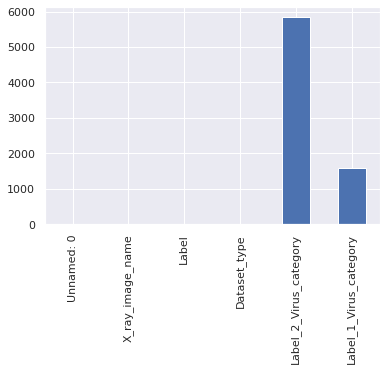

In [4]:
missing_vals = train_df.isnull().sum()
missing_vals.plot(kind = 'bar')

In [5]:
train_df.dropna(how = 'all')
train_df.isnull().sum()

Unnamed: 0                   0
X_ray_image_name             0
Label                        0
Dataset_type                 0
Label_2_Virus_category    5841
Label_1_Virus_category    1576
dtype: int64

In [6]:
train_data = train_df[train_df['Dataset_type'] == 'TRAIN']
test_data = train_df[train_df['Dataset_type'] == 'TEST']
assert train_data.shape[0] + test_data.shape[0] == train_df.shape[0]
print(f"Shape of train data : {train_data.shape}")
print(f"Shape of test data : {test_data.shape}")
test_data.sample(10)

Shape of train data : (5286, 6)
Shape of test data : (624, 6)


Unnamed: 0             X_ray_image_name     Label Dataset_type  \
5821        5844       person39_virus_85.jpeg  Pnemonia         TEST   
5757        5780   person82_bacteria_405.jpeg  Pnemonia         TEST   
5400        5423    NORMAL2-IM-0305-0001.jpeg    Normal         TEST   
5602        5625  person136_bacteria_654.jpeg  Pnemonia         TEST   
5499        5522    NORMAL2-IM-0362-0001.jpeg    Normal         TEST   
5812        5835       person44_virus_94.jpeg  Pnemonia         TEST   
5332        5355            IM-0097-0001.jpeg    Normal         TEST   
5689        5712  person109_bacteria_519.jpeg  Pnemonia         TEST   
5858        5881  person173_bacteria_831.jpeg  Pnemonia         TEST   
5658        5681       person11_virus_38.jpeg  Pnemonia         TEST   

     Label_2_Virus_category Label_1_Virus_category  
5821                    NaN                  Virus  
5757                    NaN               bacteria  
5400                    NaN                    NaN  
5602                    NaN               bacteria  
5499                    NaN                    NaN  
5812                    NaN                  Virus  
5332                    NaN                    NaN  
5689                    NaN               bacteria  
5858                    NaN               bacteria  
5658                    NaN                  Virus

Let's fill the missing values with 'unknown'

In [7]:
train_fill = train_data.fillna('unknown')
test_fill = test_data.fillna('unknown')
display(train_fill.head(5))

Unnamed: 0   X_ray_image_name   Label Dataset_type Label_2_Virus_category  \
0           0  IM-0128-0001.jpeg  Normal        TRAIN                unknown   
1           1  IM-0127-0001.jpeg  Normal        TRAIN                unknown   
2           2  IM-0125-0001.jpeg  Normal        TRAIN                unknown   
3           3  IM-0122-0001.jpeg  Normal        TRAIN                unknown   
4           4  IM-0119-0001.jpeg  Normal        TRAIN                unknown   

  Label_1_Virus_category  
0                unknown  
1                unknown  
2                unknown  
3                unknown  
4                unknown

# 3. Visualization of Unknown Data

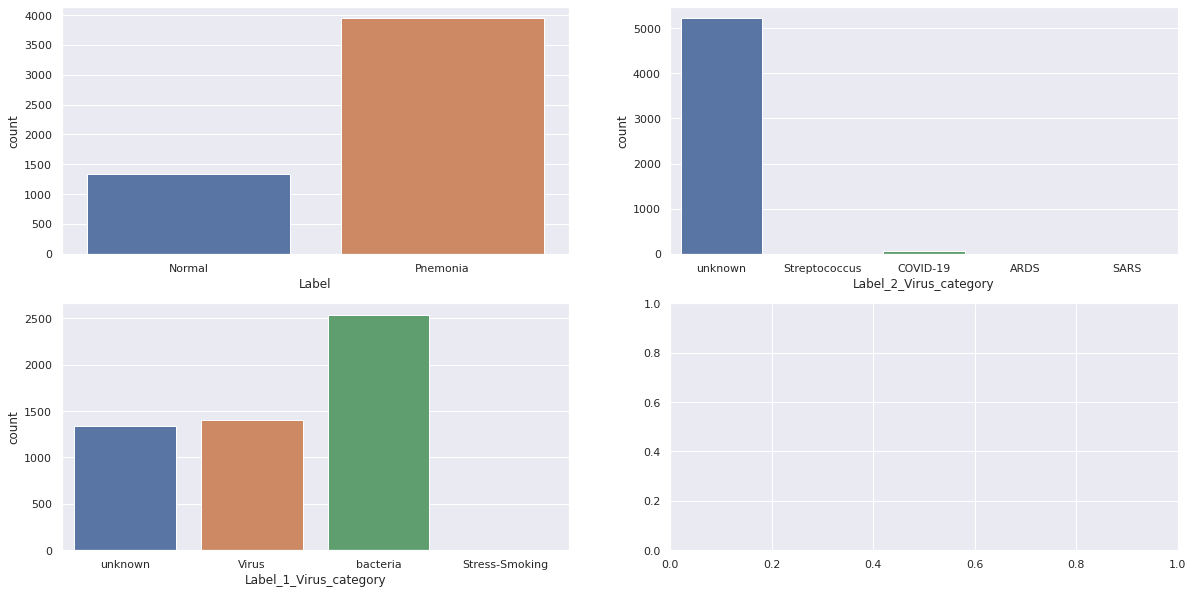

In [8]:
# Count plot for 3 attributes with unknown variable addition
targets = ['Label', 'Label_2_Virus_category', 'Label_1_Virus_category']
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.countplot(x=targets[0], data=train_fill, ax=ax[0, 0])
sns.countplot(x=targets[1], data=train_fill, ax=ax[0, 1])
sns.countplot(x=targets[2], data=train_fill, ax=ax[1, 0])
plt.show()

# 4. Display Images

In [9]:
test_img_dir = '/kaggle/input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'
train_img_dir = '/kaggle/input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'

assert os.path.isdir(test_img_dir) == True
assert os.path.isdir(train_img_dir) == True

sample_train_images = list(os.walk(train_img_dir))[0][2][:8]
sample_train_images = list(map(lambda x: os.path.join(train_img_dir, x), sample_train_images))

sample_test_images = list(os.walk(test_img_dir))[0][2][:8]
sample_test_images = list(map(lambda x: os.path.join(test_img_dir, x), sample_test_images))

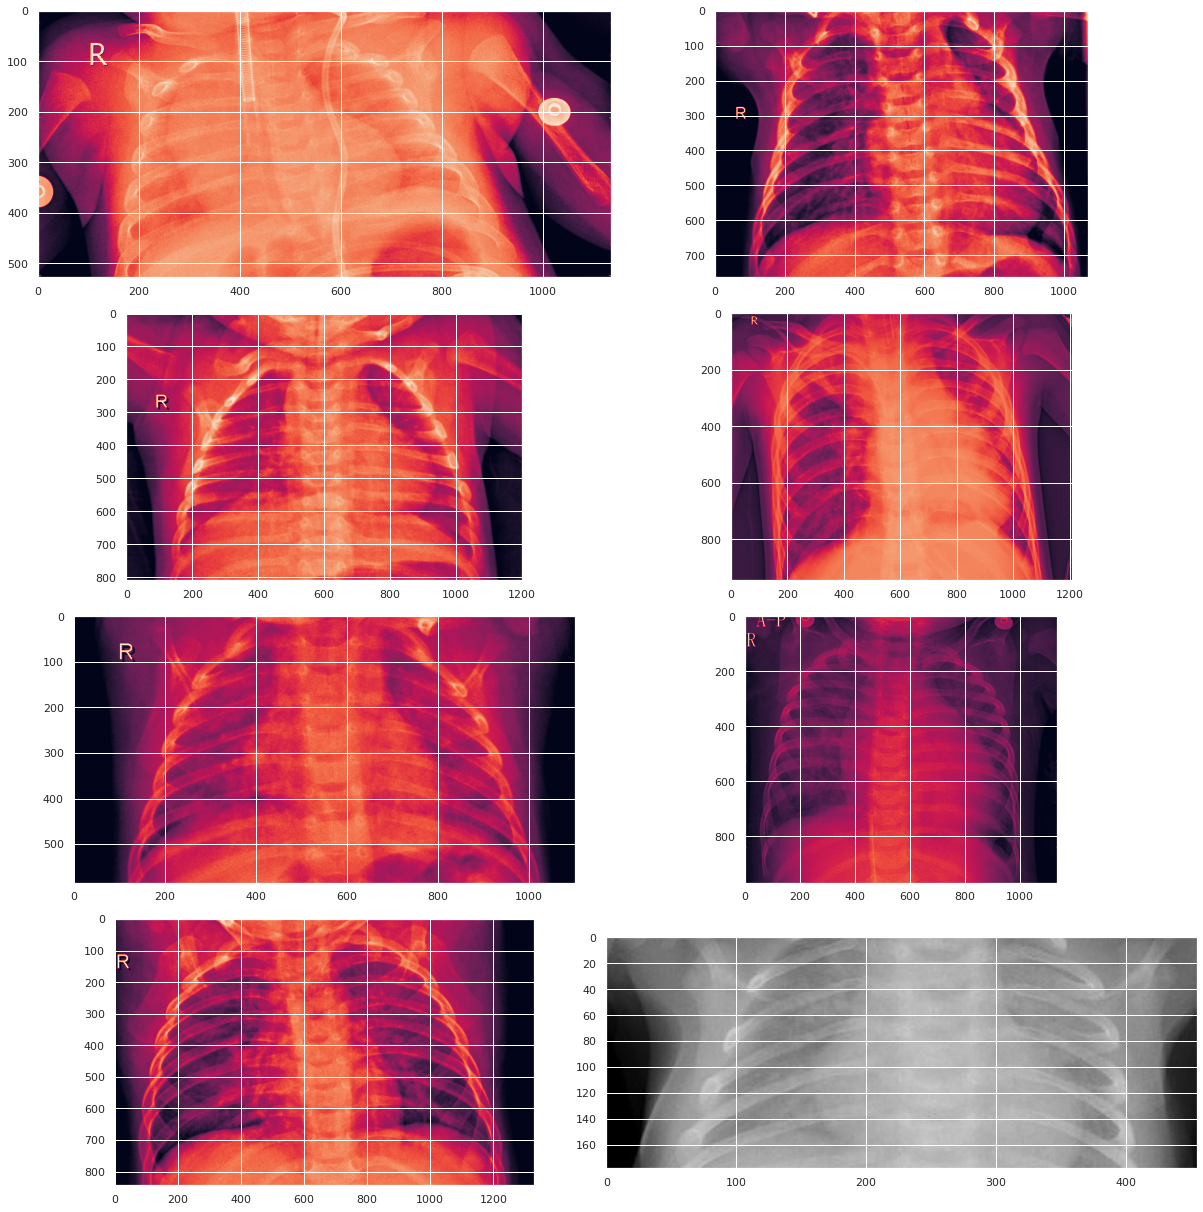

In [10]:
from PIL import Image
plt.figure(figsize = (17,17))
for iterator, filename in enumerate(sample_train_images):
    image = Image.open(filename)
    plt.subplot(4,2,iterator+1)
    plt.imshow(image)

plt.tight_layout()

Displaying test images

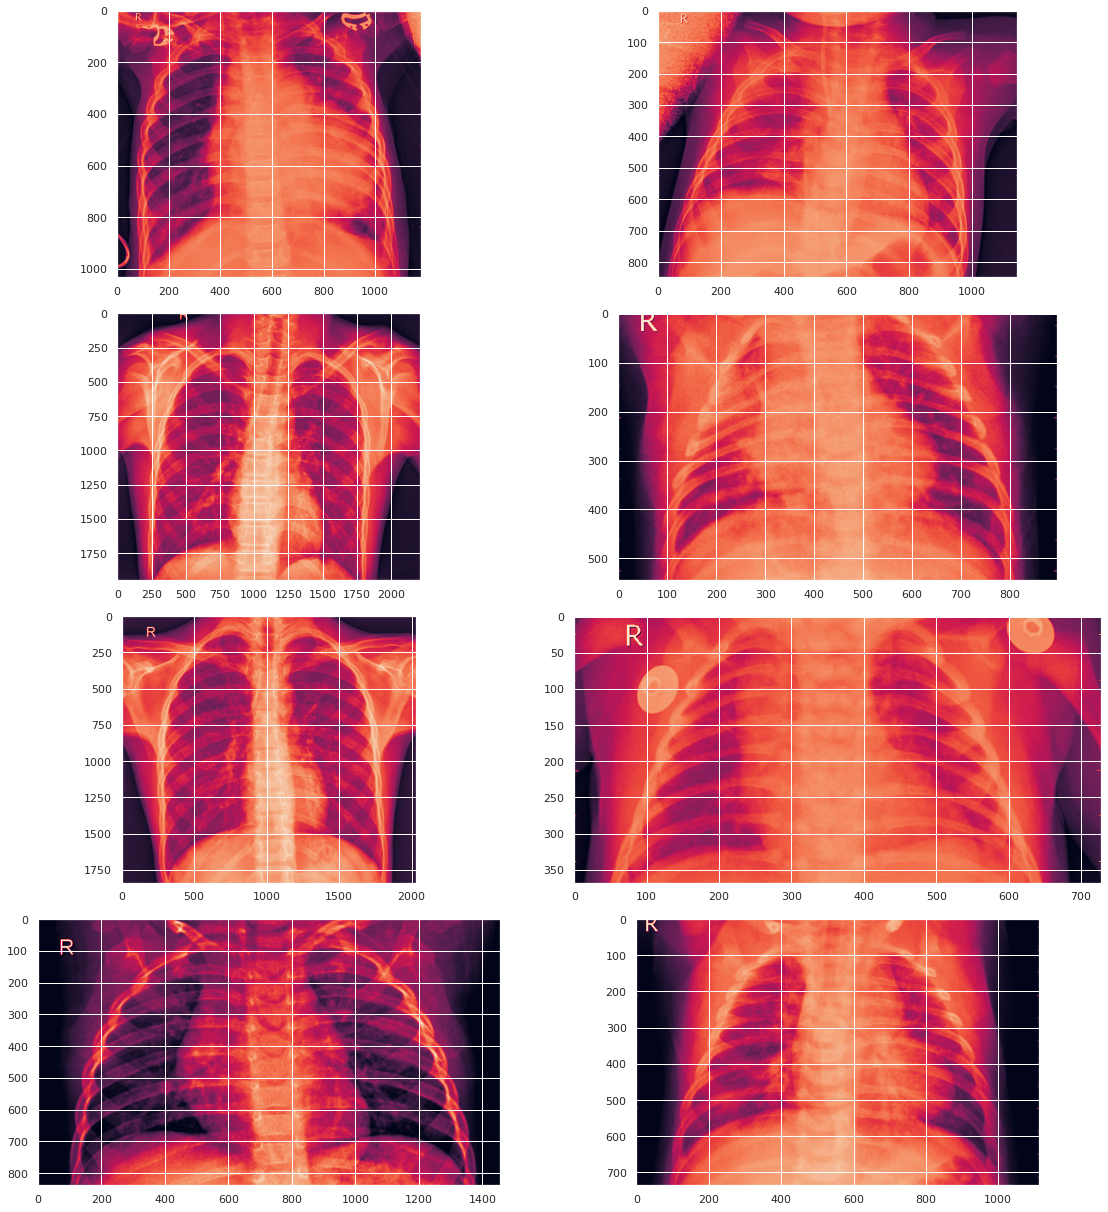

In [11]:
plt.figure(figsize = (17,17))
for iterator, filename in enumerate(sample_test_images):
    image = Image.open(filename)
    plt.subplot(4,2,iterator+1)
    plt.imshow(image)

plt.tight_layout()

# 4.1 Histogram analysis of Images

**For COVID-19 cases**

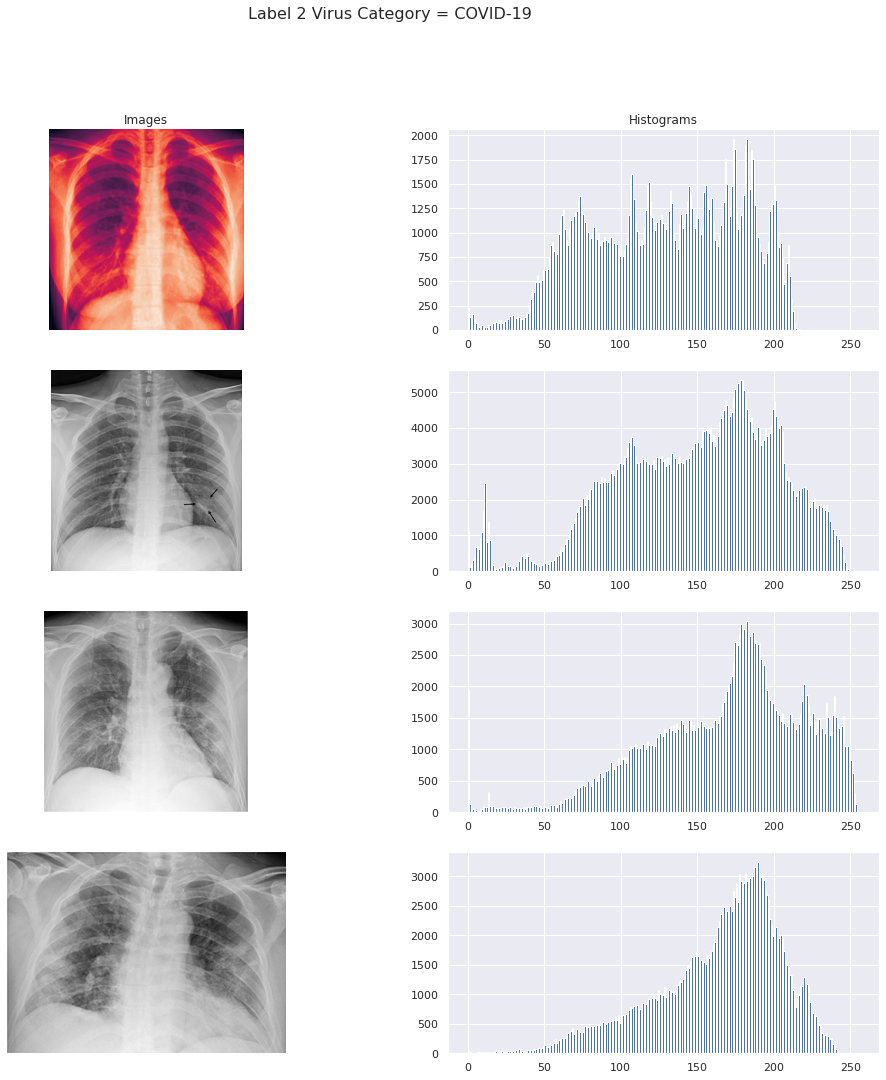

In [12]:
fig, ax = plt.subplots(4, 2, figsize=(17, 17))


covid_path = train_data[train_data['Label_2_Virus_category']=='COVID-19']['X_ray_image_name'].values

sample_covid_path = covid_path[:4]
sample_covid_path = list(map(lambda x: os.path.join(train_img_dir, x), sample_covid_path))

for row, file in enumerate(sample_covid_path):
    image = plt.imread(file)
    ax[row, 0].imshow(image)
    ax[row, 1].hist(image.ravel(), 256, [0,256])
    ax[row, 0].axis('off')
    if row == 0:
        ax[row, 0].set_title('Images')
        ax[row, 1].set_title('Histograms')
fig.suptitle('Label 2 Virus Category = COVID-19', size=16)
plt.show()

**Normal Histogram images**

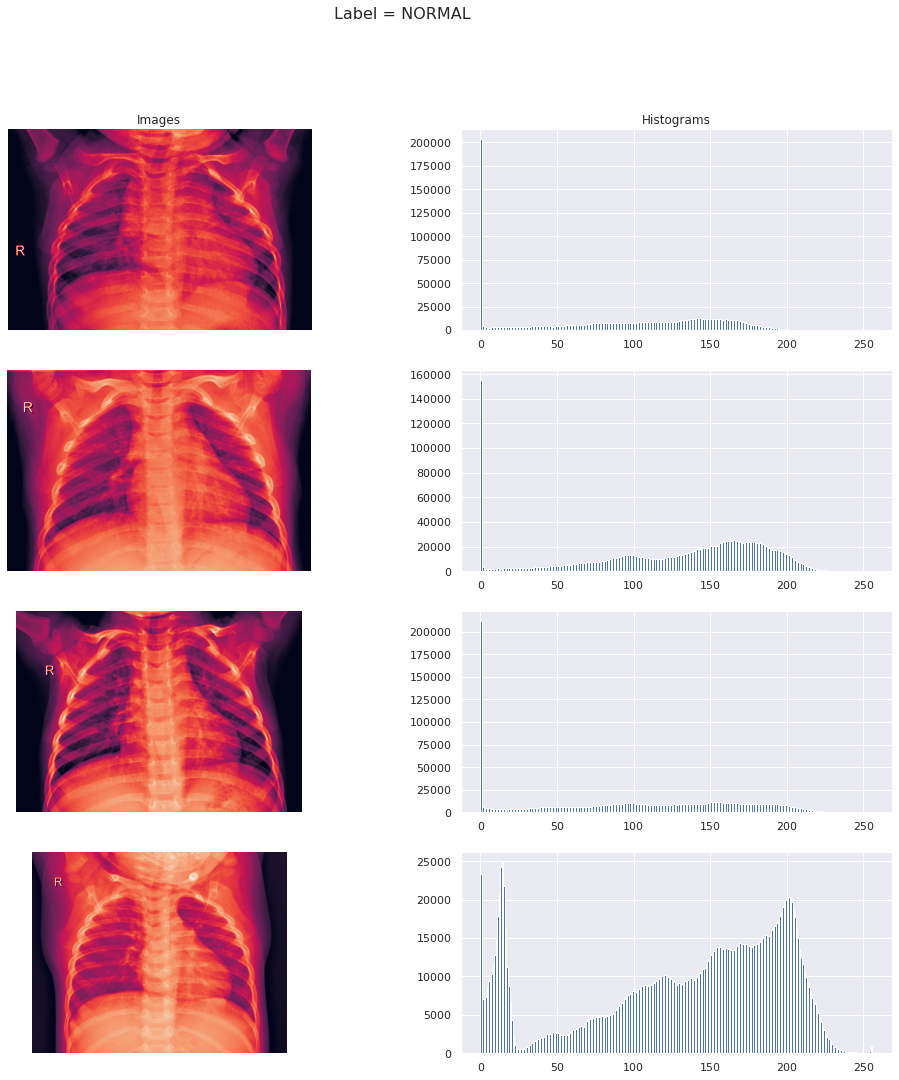

In [13]:
fig, ax = plt.subplots(4, 2, figsize=(17, 17))


normal_path = train_data[train_data['Label']=='Normal']['X_ray_image_name'].values

sample_normal_path = normal_path[:4]
sample_normal_path = list(map(lambda x: os.path.join(train_img_dir, x), sample_normal_path))

for row, file in enumerate(sample_normal_path):
    image = plt.imread(file)
    ax[row, 0].imshow(image)
    ax[row, 1].hist(image.ravel(), 256, [0,256])
    ax[row, 0].axis('off')
    if row == 0:
        ax[row, 0].set_title('Images')
        ax[row, 1].set_title('Histograms')
fig.suptitle('Label = NORMAL', size=16)
plt.show()

# 5. Image Augmentation

In [14]:
final_train_data = train_data[(train_data['Label'] == 'Normal') | 
                              ((train_data['Label'] == 'Pnemonia') & (train_data['Label_2_Virus_category'] == 'COVID-19'))]


# Create a target attribute where value = positive if 'Pnemonia + COVID-19' or value = negative if 'Normal'
final_train_data['target'] = ['negative' if holder == 'Normal' else 'positive' for holder in final_train_data['Label']]

final_train_data = shuffle(final_train_data, random_state=1)

final_validation_data = final_train_data.iloc[1000:, :]
final_train_data = final_train_data.iloc[:1000, :]

print(f"Final train data shape : {final_train_data.shape}")
final_train_data.sample(10)

Final train data shape : (1000, 7)


Unnamed: 0                X_ray_image_name   Label Dataset_type  \
211          211               IM-0375-0001.jpeg  Normal        TRAIN   
1237        1237       NORMAL2-IM-1224-0001.jpeg  Normal        TRAIN   
135          135               IM-0297-0001.jpeg  Normal        TRAIN   
246          246               IM-0416-0001.jpeg  Normal        TRAIN   
1083        1083  NORMAL2-IM-1102-0001-0001.jpeg  Normal        TRAIN   
364          364          IM-0539-0001-0002.jpeg  Normal        TRAIN   
1183        1183       NORMAL2-IM-1206-0001.jpeg  Normal        TRAIN   
82            82               IM-0277-0001.jpeg  Normal        TRAIN   
1311        1311       NORMAL2-IM-1385-0001.jpeg  Normal        TRAIN   
682          682       NORMAL2-IM-0531-0001.jpeg  Normal        TRAIN   

     Label_2_Virus_category Label_1_Virus_category    target  
211                     NaN                    NaN  negative  
1237                    NaN                    NaN  negative  
135                     NaN                    NaN  negative  
246                     NaN                    NaN  negative  
1083                    NaN                    NaN  negative  
364                     NaN                    NaN  negative  
1183                    NaN                    NaN  negative  
82                      NaN                    NaN  negative  
1311                    NaN                    NaN  negative  
682                     NaN                    NaN  negative

In [15]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    zoom_range=0.5,
)

test_image_generator = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_image_generator.flow_from_dataframe(
    dataframe=final_train_data,
    directory=train_img_dir,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=16,
    seed=2020,
    shuffle=True,
    class_mode='binary'
)

validation_generator = train_image_generator.flow_from_dataframe(
    dataframe=final_validation_data,
    directory=train_img_dir,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=16,
    seed=2020,
    shuffle=True,
    class_mode='binary'
)

test_generator = test_image_generator.flow_from_dataframe(
    dataframe=test_data,
    directory=test_img_dir,
    x_col='X_ray_image_name',
    target_size=(224, 224),
    shuffle=False,
    batch_size=16,
    class_mode=None)

Found 1000 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.
Found 624 validated image filenames.


# 6. Model Development

In [16]:
IMG_W = 224
IMG_H = 224
CHANNELS = 3

INPUT_SHAPE = (IMG_W, IMG_H, CHANNELS)
NB_CLASSES = 2
EPOCHS = 30
BATCH_SIZE = 6

# 6.1 Convolutional Neural Network

In [17]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(Conv2D(250,(3,3)))
model.add(Activation("relu"))
  
model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(AvgPool2D(2,2))
model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(AvgPool2D(2,2))

model.add(Conv2D(256,(2,2)))
model.add(Activation("relu"))
model.add(MaxPool2D(2,2))
    
model.add(Flatten())
model.add(Dense(32))
model.add(Dropout(0.25))
model.add(Dense(1))
model.add(Activation("sigmoid"))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        1

In [19]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.9325):
            print("\nReached 94.25% accuracy so cancelling training!")
            self.model.stop_training = True
callbacks = myCallback()

In [20]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history = model.fit_generator(train_generator,
                              steps_per_epoch = 150,
                   validation_data=validation_generator,
                   epochs=15,
                             validation_steps=30)

Train for 150 steps, validate for 30 steps
Epoch 1/15
 63/150 [===========>..................] - ETA: 1:33 - loss: 0.9132 - accuracy: 0.9490

**Plots to estimate loss and accuracy**

Text(0.5, 1.0, 'Metrics estimations')

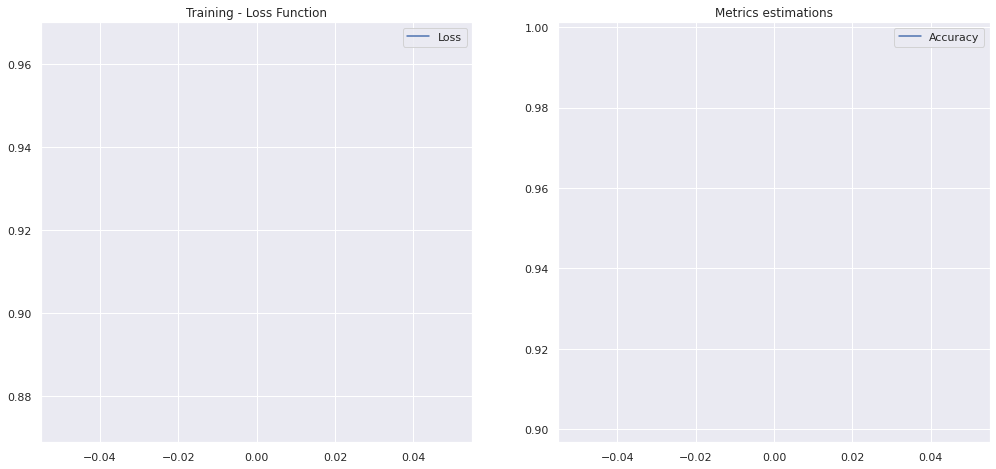

In [21]:
plt.figure(figsize=(17,17))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.legend()
plt.title('Train - Accuracy')

plt.legend()
plt.title('Metrics estimations')


# 6.2 Transfer Learning

# DenseNet121

In [22]:
dense_model = Sequential()
dense_model.add(DenseNet121(include_top=False, pooling = 'avg', weights='imagenet',input_shape=(224, 224, 3), classes=2))
dense_model.add(Dense(2, activation='softmax'))
dense_model.layers[0].trainable = False
dense_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

29089792/29084464 [==============================] - 0s 0us/step


In [23]:
dense_history = dense_model.fit_generator(train_generator,
                              #steps_per_epoch = 150
                   validation_data=validation_generator,
                   epochs=15
                             #validation_steps=30
                                         )

Train for 63 steps, validate for 25 steps
Epoch 1/15
63/63 [==============================] - 99s 2s/step - loss: 0.7581 - accuracy: 0.5000 - val_loss: 0.7529 - val_accuracy: 0.5000
Epoch 2/15
63/63 [==============================] - 105s 2s/step - loss: 0.7304 - accuracy: 0.5000 - val_loss: 0.7297 - val_accuracy: 0.5000
Epoch 3/15
63/63 [==============================] - 88s 1s/step - loss: 0.7129 - accuracy: 0.5000 - val_loss: 0.7205 - val_accuracy: 0.5000
Epoch 4/15
63/63 [==============================] - 90s 1s/step - loss: 0.7082 - accuracy: 0.5000 - val_loss: 0.7112 - val_accuracy: 0.5000
Epoch 5/15
63/63 [==============================] - 88s 1s/step - loss: 0.7034 - accuracy: 0.5000 - val_loss: 0.7062 - val_accuracy: 0.5000
Epoch 6/15
63/63 [==============================] - 89s 1s/step - loss: 0.7006 - accuracy: 0.5000 - val_loss: 0.7059 - val_accuracy: 0.5000
Epoch 7/15
63/63 [==============================] - 87s 1s/step - loss: 0.6975 - accuracy: 0.5000 - val_loss: 0.6995 

Text(0.5, 1.0, 'Train - Accuracy')

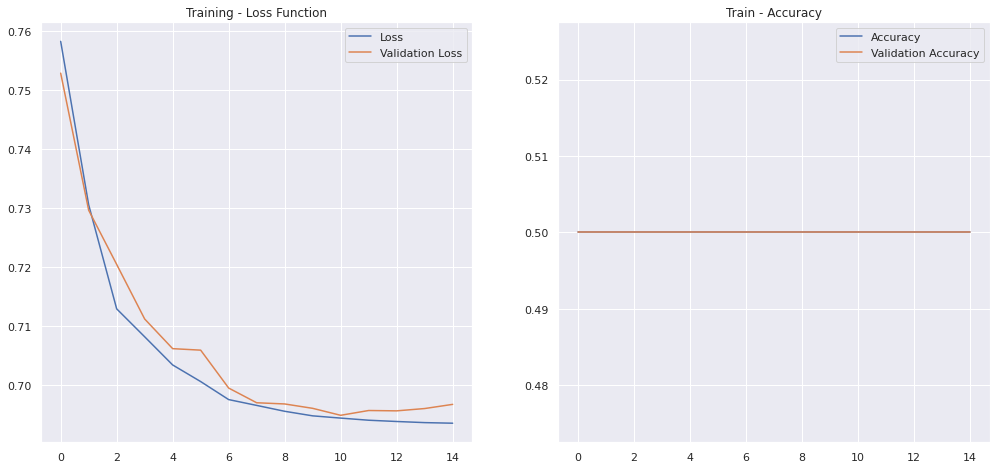

In [24]:
plt.figure(figsize=(17,17))

plt.subplot(2, 2, 1)
plt.plot(dense_history.history['loss'], label='Loss')
plt.plot(dense_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(dense_history.history['accuracy'], label='Accuracy')
plt.plot(dense_history.history['val_accuracy'], label='Validation Accuracy')

plt.legend()
plt.title('Train - Accuracy')

# MobileNetV2

In [25]:
mob_model = Sequential()
mob_model.add(tf.keras.applications.MobileNetV2(include_top=False, pooling = 'avg', weights='imagenet',input_shape=(224, 224, 3), classes=2))
mob_model.add(Dense(2, activation='softmax'))
mob_model.layers[0].trainable = False
mob_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

9412608/9406464 [==============================] - 0s 0us/step


In [26]:
mob_history = mob_model.fit_generator(train_generator,
                              #steps_per_epoch = 150,
                   validation_data=validation_generator,
                   epochs=15
                             #validation_steps=30
                                     )

Train for 63 steps, validate for 25 steps
Epoch 1/15
63/63 [==============================] - 90s 1s/step - loss: 0.7859 - accuracy: 0.5000 - val_loss: 0.7544 - val_accuracy: 0.5000
Epoch 2/15
63/63 [==============================] - 87s 1s/step - loss: 0.7305 - accuracy: 0.5000 - val_loss: 0.7444 - val_accuracy: 0.5000
Epoch 3/15
63/63 [==============================] - 87s 1s/step - loss: 0.7209 - accuracy: 0.5000 - val_loss: 0.7406 - val_accuracy: 0.5000
Epoch 4/15
63/63 [==============================] - 88s 1s/step - loss: 0.7153 - accuracy: 0.5000 - val_loss: 0.7285 - val_accuracy: 0.5000
Epoch 5/15
63/63 [==============================] - 87s 1s/step - loss: 0.7105 - accuracy: 0.5000 - val_loss: 0.7323 - val_accuracy: 0.5000
Epoch 6/15
63/63 [==============================] - 87s 1s/step - loss: 0.7079 - accuracy: 0.5000 - val_loss: 0.7188 - val_accuracy: 0.5000
Epoch 7/15
63/63 [==============================] - 87s 1s/step - loss: 0.7058 - accuracy: 0.5000 - val_loss: 0.7153 -

Text(0.5, 1.0, 'Train - Accuracy')

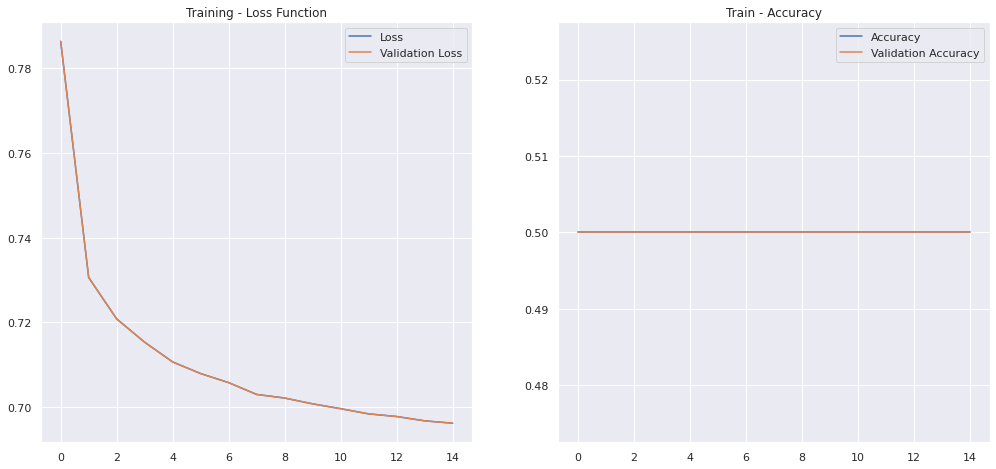

In [27]:
plt.figure(figsize=(17,17))

plt.subplot(2, 2, 1)
plt.plot(mob_history.history['loss'], label='Loss')
plt.plot(mob_history.history['loss'], label='Validation Loss')

plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(mob_history.history['accuracy'], label='Accuracy')
plt.plot(mob_history.history['val_accuracy'], label='Validation Accuracy')


plt.legend()
plt.title('Train - Accuracy')

In [28]:
model.predict(validation_generator)

array([[0.07125989],
       [0.06900445],
       [0.07335843],
       [0.03309006],
       [0.08343986],
       [0.04540696],
       [0.06990601],
       [0.03662699],
       [0.02855157],
       [0.05738729],
       [0.05526262],
       [0.03092437],
       [0.03349474],
       [0.05935083],
       [0.04421068],
       [0.04786777],
       [0.05810236],
       [0.07587207],
       [0.07447246],
       [0.03562565],
       [0.05065351],
       [0.07669189],
       [0.04844682],
       [0.0542205 ],
       [0.05280168],
       [0.03628366],
       [0.069519  ],
       [0.06638002],
       [0.072861  ],
       [0.03099625],
       [0.0474745 ],
       [0.07400499],
       [0.04459745],
       [0.06294358],
       [0.0737424 ],
       [0.06816843],
       [0.05168147],
       [0.02585427],
       [0.0721363 ],
       [0.07733335],
       [0.02302709],
       [0.05250977],
       [0.06666626],
       [0.08301972],
       [0.0607121 ],
       [0.04188457],
       [0.06207485],
       [0.065

In [29]:
dense_model.predict(validation_generator)

array([[0.4526716 , 0.5473284 ],
       [0.43891224, 0.5610878 ],
       [0.4426878 , 0.5573122 ],
       [0.4745186 , 0.52548146],
       [0.43169805, 0.568302  ],
       [0.45286983, 0.5471301 ],
       [0.4215016 , 0.57849836],
       [0.42618513, 0.57381487],
       [0.49311307, 0.5068869 ],
       [0.4323892 , 0.5676108 ],
       [0.46635795, 0.53364205],
       [0.4654868 , 0.53451324],
       [0.47912428, 0.52087575],
       [0.48013258, 0.5198674 ],
       [0.45216793, 0.547832  ],
       [0.452008  , 0.547992  ],
       [0.4799548 , 0.52004516],
       [0.4602507 , 0.53974926],
       [0.44956398, 0.5504361 ],
       [0.4668632 , 0.5331368 ],
       [0.47836158, 0.52163845],
       [0.470721  , 0.529279  ],
       [0.44351968, 0.5564803 ],
       [0.44831777, 0.5516822 ],
       [0.4350741 , 0.5649259 ],
       [0.46514425, 0.5348557 ],
       [0.44878787, 0.5512121 ],
       [0.467795  , 0.532205  ],
       [0.45188415, 0.54811585],
       [0.46221903, 0.537781  ],
       [0.

In [30]:
mob_model.predict(validation_generator)

array([[0.49463546, 0.5053645 ],
       [0.4404752 , 0.55952483],
       [0.49360964, 0.50639033],
       [0.50298136, 0.49701864],
       [0.57723486, 0.4227651 ],
       [0.49477395, 0.505226  ],
       [0.45591193, 0.54408807],
       [0.48399818, 0.5160018 ],
       [0.38834757, 0.61165243],
       [0.5239558 , 0.47604415],
       [0.52280337, 0.47719666],
       [0.47298002, 0.52702   ],
       [0.45054886, 0.5494512 ],
       [0.39664418, 0.6033558 ],
       [0.5199937 , 0.48000628],
       [0.4604652 , 0.5395348 ],
       [0.48027304, 0.51972693],
       [0.4614476 , 0.53855246],
       [0.5299837 , 0.4700163 ],
       [0.42105067, 0.57894933],
       [0.54759264, 0.4524073 ],
       [0.44486707, 0.5551329 ],
       [0.44797286, 0.55202717],
       [0.50166553, 0.49833444],
       [0.4717763 , 0.52822375],
       [0.44177657, 0.5582234 ],
       [0.5251287 , 0.47487125],
       [0.4413419 , 0.5586581 ],
       [0.39723492, 0.6027651 ],
       [0.4376115 , 0.56238854],
       [0.

In [31]:
label = validation_generator.classes

# CNN predictions

In [32]:
pred= model.predict(validation_generator)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (validation_generator.class_indices)
labels2 = dict((v,k) for k,v in labels.items())
predictions = [labels2[k] for k in predicted_class_indices]
print(predicted_class_indices)
print (labels)
print (predictions)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
{'negative': 0, 'positive': 1}
['negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 

In [33]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(predicted_class_indices,label)
cf_matrix

array([[377,  23],
       [  0,   0]])

In [34]:
exp_series = pd.Series(label)
pred_series = pd.Series(predicted_class_indices)
pd.crosstab(exp_series, pred_series, rownames=['Actual'], colnames=['Predicted'],margins=True)

Predicted    0  All
Actual             
0          377  377
1           23   23
All        400  400

# DenseNet predictions

In [35]:
pred= dense_model.predict(validation_generator)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (validation_generator.class_indices)
labels2 = dict((v,k) for k,v in labels.items())
predictions = [labels2[k] for k in predicted_class_indices]
print(predicted_class_indices)
print (labels)
print (predictions)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1]
{'negative': 0, 'positive': 1}
['positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 

In [36]:
cf_matrix = confusion_matrix(predicted_class_indices,label)
cf_matrix

array([[  7,   1],
       [370,  22]])

In [37]:
exp_series = pd.Series(label)
pred_series = pd.Series(predicted_class_indices)
pd.crosstab(exp_series, pred_series, rownames=['Actual'], colnames=['Predicted'],margins=True)

Predicted  0    1  All
Actual                
0          7  370  377
1          1   22   23
All        8  392  400

# MobileNet predictions

In [38]:
pred= mob_model.predict(validation_generator)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (validation_generator.class_indices)
labels2 = dict((v,k) for k,v in labels.items())
predictions = [labels2[k] for k in predicted_class_indices]
print(predicted_class_indices)
print (labels)
print (predictions)

[1 1 0 1 0 0 0 1 1 0 0 1 1 1 0 1 0 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0 1 0 1 1 1
 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0
 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 1 1
 1 1 0 0 1 1 1 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0
 0 0 1 1 0 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 0 1 0 1 1 0
 0 1 1 0 1 1 0 1 1 0 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0
 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 1 0
 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 1
 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 0
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 0 0 1 1 1 1 1 0 1 1 0 1
 1 1 0 0 1 1 0 1 1 0 1 0 0 1 0 1 0 1 1 0 0 1 1 0 1 0 1 1 1 0]
{'negative': 0, 'positive': 1}
['positive', 'positive', 'negative', 'positive', 'negative', 'negative', 'negative', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 

In [39]:
cf_matrix = confusion_matrix(predicted_class_indices,label)
cf_matrix

array([[131,   6],
       [246,  17]])

In [40]:
exp_series = pd.Series(label)
pred_series = pd.Series(predicted_class_indices)
pd.crosstab(exp_series, pred_series, rownames=['Actual'], colnames=['Predicted'],margins=True)

Predicted    0    1  All
Actual                  
0          131  246  377
1            6   17   23
All        137  263  400

# 8. References
Thanks to some amazing notebooks I was able to learn how to display images in an orderly fashion and was able to apply transfer learning CNN in COVID related applications.
1. https://www.kaggle.com/adityam1311/covid-19-x-ray-images-eda-models/notebook
2. https://www.kaggle.com/eswarchandt/covid-19-detection-from-lung-x-rays